## Flow Heater
* Heated pipe of 1 m length with water inside
* Water flows at the beginning but stops after .25 minutes 
* The lengthwise heat transfer in water is initially modelled as a mass flow with heat transport
* After the flow stops the heat transfer is lengthwise modeled as heat conduction

In [1]:
from math import tau
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
pv.set_jupyter_backend('static')
from thermca import *

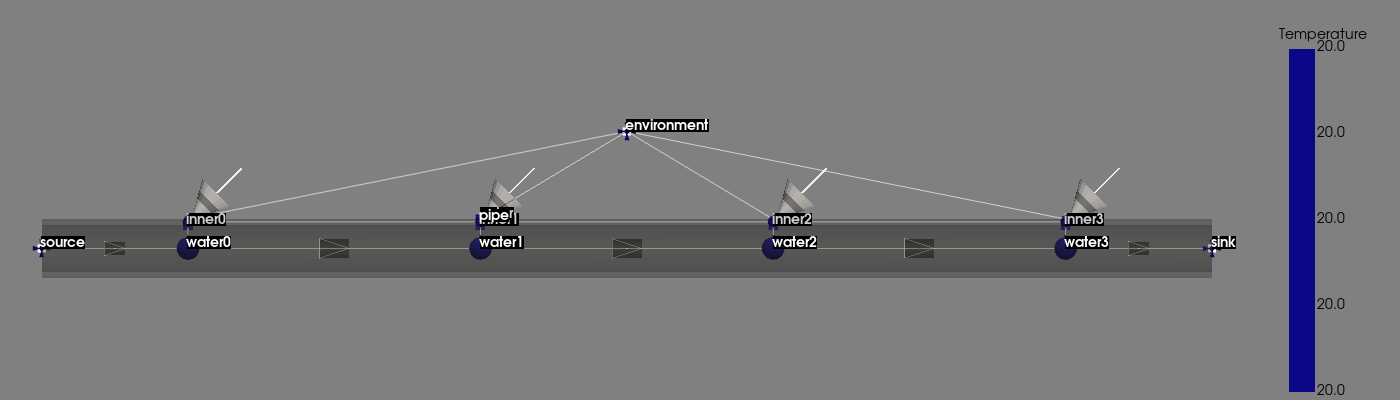

In [2]:
segm_len = .25

with Asm() as pipe_asm:
    pipe0 = Cyl(
        inner_rad=.02,
        outer_rad=.025,
        lgth=segm_len,
    )
    pipe1 = Cyl(
        posn=(segm_len, 0., 0.),
        inner_rad=.02,
        outer_rad=.025,
        lgth=segm_len,
    )
    pipe2 = Cyl(
        posn=(2 * segm_len, 0., 0.),
        inner_rad=.02,
        outer_rad=.025,
        lgth=segm_len,
    )
    pipe3 = Cyl(
        posn=(3 * segm_len, 0., 0.),
        inner_rad=.02,
        outer_rad=.025,
        lgth=segm_len,
    )
    Surf(name='inner0', faces=[pipe0.face.inner])
    Surf(name='inner1', faces=[pipe1.face.inner])
    Surf(name='inner2', faces=[pipe2.face.inner])
    Surf(name='inner3', faces=[pipe3.face.inner])
    Surf(
        name='outer', 
        faces=[
            pipe0.face.outer, 
            pipe1.face.outer, 
            pipe2.face.outer, 
            pipe3.face.outer,
        ]
    )

with Model() as model:
    pipe = LPPart(
        asm=pipe_asm,
        init_temp=20.,
        matl=solids.steel,
        name='pipe',
    )
    HeatSource(pipe.surf.outer, 1000.)
    env = BoundNode(
        posn=(.5, .1, 0.),
        temp=20.,
        name='environment'
    )
    FilmLink(
        pipe.surf.outer,
        env,
        combd_film.conv_radn_room(),
    )
    # Water with source and sink
    cs_area = tau/2.*pipe0.inner_rad**2
    vol = cs_area*.5
    source = BoundNode(
        temp=20,
        posn=(.0, 0., 0.),
        name='source',
    )
    MatlNode.is_temp_dep = True
    water0 = MatlNode(
        matl=fluids.water,
        init_temp=20.,  
        vol=vol,        
        posn=(.125, 0., 0.),
        name='water0',
    )
    water1 = MatlNode(
        matl=fluids.water,
        init_temp=20.,
        vol=vol, 
        posn=(.25+.125, 0., 0.),
        name='water1',
    )
    water2 = MatlNode(
        matl=fluids.water,
        init_temp=20.,
        vol=vol,    
        posn=(.5+.125, 0., 0.),
        name='water2',
    )
    water3 = MatlNode(
        matl=fluids.water,
        init_temp=20.,
        vol=vol,    
        posn=(.75+.125, 0., 0.),
        name='water3',
    )
    sink = BoundNode(
        temp=20.,
        posn=(1., 0., 0.),
        name='sink',
    )
    # Water flow and conductance
    # Beginning with volume flow, later normal conduction between water nodes
    vol_flow_on = Input(
        [[0, True], 
         [.25*60, False]]
    )
    water_vel = 1.5
    vol_flow = water_vel*cs_area
    cond = fluids.water.condy_interp(20.)*cs_area/segm_len*1000.
    def vol_flow_rightwards(tempd, temps, matl, cond=cond):
        if vol_flow_on.value:
            return vol_flow  # Volume flow rightwards        
        return cond/matl.vol_capy_interp((tempd + temps)/2)  # Normal conductance
    def vol_flow_leftwards(tempd, temps, matl, cond=cond):
        if vol_flow_on.value:
            return cond/matl.vol_capy_interp((tempd + temps)/2)  # Normal conductance leftwards
        return cond/matl.vol_capy_interp((tempd + temps)/2)  # Normal conductance
    FilmLink.pairs(
        zip(
            [pipe.surf.inner0, pipe.surf.inner1, pipe.surf.inner2, pipe.surf.inner3], 
            [water0, water1, water2, water3],
        ),
        forced_conv.pipe(
            vel=water_vel, 
            lgth=1, 
            hydr_rad=pipe0.inner_rad,
        ),
        fluids.water,
    )
    FlowLink(water0, source, vol_flow_rightwards, fluids.water)
    FlowLink(source, water0, vol_flow_leftwards, fluids.water)
    FlowLink(water1, water0, vol_flow_rightwards, fluids.water)
    FlowLink(water0, water1, vol_flow_leftwards, fluids.water)
    FlowLink(water2, water1, vol_flow_rightwards, fluids.water)
    FlowLink(water1, water2, vol_flow_leftwards, fluids.water)
    FlowLink(water3, water2, vol_flow_rightwards, fluids.water)
    FlowLink(water2, water3, vol_flow_leftwards, fluids.water)
    FlowLink(sink, water3, vol_flow_rightwards, fluids.water)
    FlowLink(water3, sink, vol_flow_leftwards, fluids.water)
    
net = Network(model)
figsize=(17, 3)  # Adjust desired figure size here

def show_thight(plot):
    plot.camera.zoom(3)
    plot.window_size=(1400, 400)
    posn = plot.camera_position
    # tuple: camera location, focus point, viewup vector
    # camera_position = [(x,y,z), (fx,fy,fz,), (nx,ny,nz)]
    plot.camera_position = [
        (posn[0][0] + segm_len/4, posn[0][1], posn[0][2]),
        (posn[1][0] + segm_len/4, posn[1][1], posn[1][2]), 
        posn[2],
    ]
    plot.show()

show_thight(net.plot(draw_2d=True))

In [3]:
sim_period = .5*60
result = net.sim((0., sim_period), rel_tol=1e-5)

Simulation run progress, speed as sim. time vs. real time:
 0% 100% done.


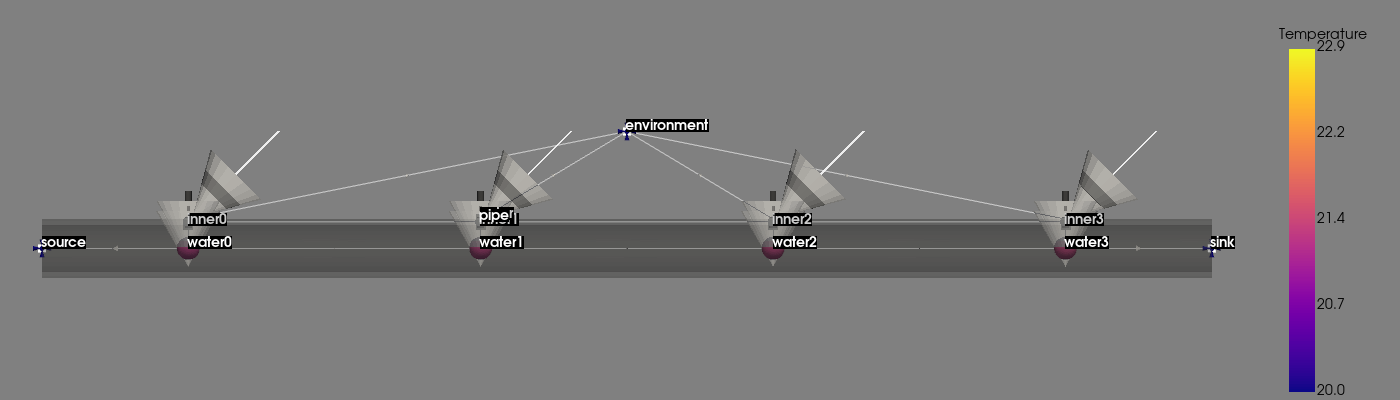

In [4]:
show_thight(result.plot(draw_2d=True))

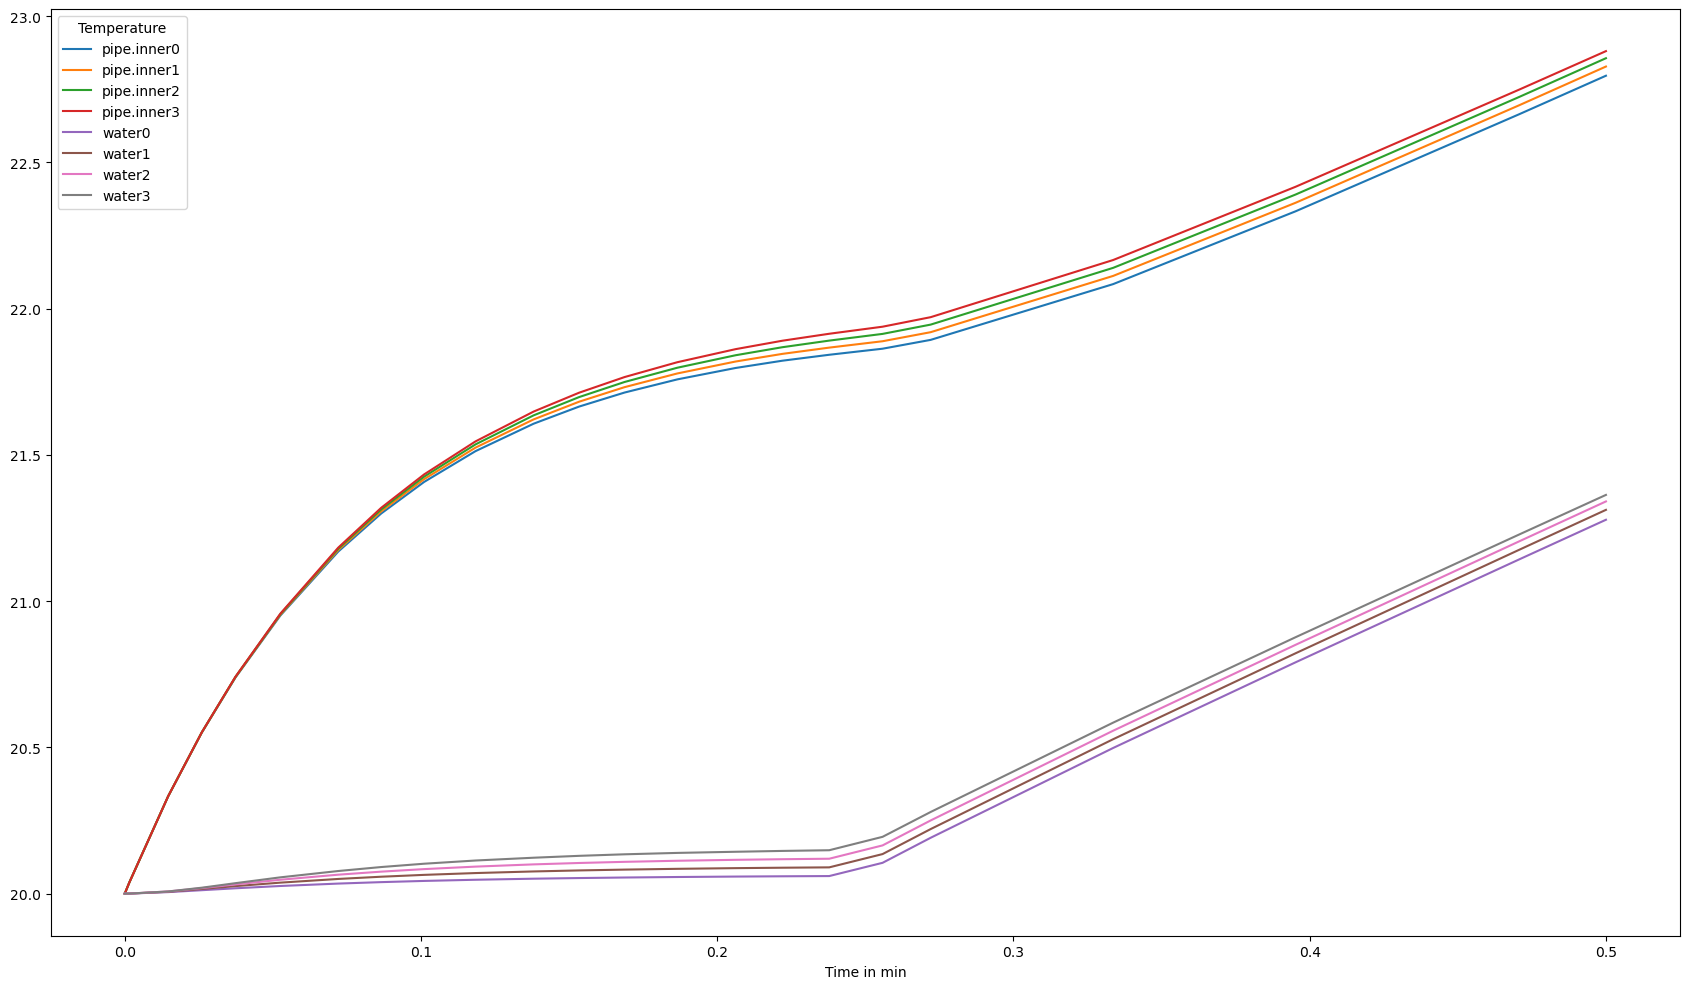

In [5]:
import pandas as pd
temp_df = pd.concat([
    result[pipe.surf.inner0].temp_frame(),
    result[pipe.surf.inner1].temp_frame(),
    result[pipe.surf.inner2].temp_frame(),
    result[pipe.surf.inner3].temp_frame(),
    result[water0].temp_frame(),
    result[water1].temp_frame(),
    result[water2].temp_frame(),
    result[water3].temp_frame(),
], axis=1)
temp_df.index /= 60.
temp_df.index.name = 'Time in min'
fig, ax = plt.subplots(figsize=(17, 10))
temp_df.plot(ax=ax);
fig.tight_layout()